In [0]:
!pip install torch
!pip install torchvision
!pip install Pillow==4.0.0
!pip install -U -q PyDrive

In [0]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from zipfile import ZipFile
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
%matplotlib inline

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
listed = drive.ListFile().GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

In [0]:
downloaded = drive.CreateFile({'id': '11j1LyGLuq-HIHEgPNlzcxg0pO57rBA2y'})
downloaded.GetContentFile('train.zip')
with ZipFile("train.zip", 'r') as z:
    z.extractall()
os.remove("train.zip")

In [0]:
class TGSSaltTrainDataset(Dataset):
    def __init__(self, image_dir,mask_dir,depth_csv,train_csv):
        self.image_dir=image_dir
        self.mask_dir=mask_dir
        
#         depth=pd.read_csv(depth_csv)
#         depth["z"]=(depth["z"]-depth["z"].min())/(depth["z"].max()-depth["z"].min())
        self.filter = np.array([(0,-1,-1,-1),(1,0,0,0),(1,0,1,0),(0,1,0,1)])/8
        self.input = pd.read_csv(train_csv)
        self.input['z'] = (self.input['z']-self.input['z'].min())/(self.input['z'].max()-self.input['z'].min())
        self.input.drop(['rle_mask'],axis=1,inplace=True)
#         self.input = self.input.merge(depth,how="left",on="id")
        
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx,0]+".png")
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        img = torch.tensor(img).view(101,101).float()
      
        mask_name = os.path.join(self.mask_dir,self.input.iloc[idx,0]+".png")
        mask = cv2.imread(mask_name)
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        mask = torch.tensor(mask).float()/255
        depth = self.input.iloc[idx,1].reshape(1)
        return img,mask,depth

In [0]:
train_dataset = TGSSaltTrainDataset("train/images","train/masks","depths.csv","train.csv")

In [0]:
train_dataset.input = train_dataset.input[:200]

In [0]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    uploaded = drive.CreateFile({'title': 'TGSUNet_epoch'+str(state['epoch'])+'.pt'})
    uploaded.SetContentFile(filename)
    uploaded.Upload()
def load_checkpoint(args):
     
    if os.path.isfile(args):
        print("=> loading checkpoint '{}'".format(args))
        checkpoint = torch.load(args)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
        

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.0)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True,up_size=None,padding=None):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            if up_size:
                self.up = nn.Upsample(size= up_size, mode='bilinear', align_corners=True)
            else:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            if padding:
                self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2,output_padding=padding)
            else:
                self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2 , int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
class conv3d(nn.Module):
    '''
    Takes a image with given number of channels and performs 3d convolution and then returns the image as 2d
    '''
    def __init__(self):
        super(conv3d, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, 2,stride=2,padding=1)
        self.conv2 = nn.Conv3d(4, 16 ,4,stride=2,padding=1)

    def forward(self, x):
        x.unsqueeze_(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1,512,6,6)
        return x

class DN(nn.Module):
    '''
    @IN
    img: A tensor representing the grayscaled image; shape:[batch_size,1,101,101]
    d: The z index of the image
    
    @OUT
    shape:[batch_size,1,101,101] tensor representing the features found by kernel(3*3) created from depth value
    '''
    def __init__(self):
        super(DN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(4,9,bias=False),
                                   nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(9,9,bias=True),
                                   nn.Sigmoid())
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,stride=1,padding=1,bias=False)
        self.non_linear1 = nn.ReLU()
    def forward(self,x,d):
        d= d.view(1)
        ker = torch.tensor([d,d**2,d**3,1]).float().cuda()
#         print(ker)
        ker = self.layer1(ker)
        ker = self.layer2(ker).view(1,1,3,3)
        self.conv1.weight = nn.Parameter(ker)
        x = self.non_linear1(self.conv1(x))
        return x
class UNet(nn.Module):
    def __init__(self,debug=False):
        super(UNet, self).__init__()
        self.debug = debug
        self.inc = inconv(1, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256,up_size = (12,12),bilinear=False)
        self.up2 = up(512, 128,up_size = (25,25))
        self.up3 = up(256, 64,up_size = (50,50),bilinear=False)
        self.up4 = up(128, 64,up_size = (101,101))
        self.outc = outconv(64, 1)

    def forward(self, x):
        x.unsqueeze_(1)
        if self.debug: print(x.shape)
        x1 = self.inc(x)
        if self.debug: print(x1.shape)
        x2 = self.down1(x1)
        if self.debug: print(x2.shape)
        x3 = self.down2(x2)
        if self.debug: print(x3.shape)
        x4 = self.down3(x3)
        if self.debug: print(x4.shape)
        x5 = self.down4(x4)
        if self.debug: print(x5.shape)
        if self.debug: print('before up')
        x = self.up1(x5, x4)
        if self.debug: print(x.shape)
        x = self.up2(x, x3)
        if self.debug: print(x.shape)
        x = self.up3(x, x2)
        if self.debug: print(x.shape)
        x = self.up4(x, x1)
        if self.debug: print(x.shape)
        x = self.outc(x)
        if self.debug: print(x.shape)
        return x.squeeze(1)

In [0]:
class UDNet(nn.Module):
    def __init__(self,debug=False):
        super(UDNet,self).__init__()
#         self.dn = DN()
        self.un1 = UNet(debug=debug)
        self.un2 = UNet(debug=debug)
    def forward(self,x,d):
        x = self.un1(x)
#         x.unsqueeze_(1)
#         x = self.dn(x,d)
#         x.squeeze_(1)
        x = self.un2(x)
        return x

In [0]:
model = UDNet(debug=False).cuda()
x = torch.randn(10,101,101).cuda()
print(model(x,torch.tensor(train_dataset[1][2][0])).shape)

In [0]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [0]:
batch_size = 20
validation_split = 0.1
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=validation_sampler)

In [0]:
class BinaryCrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        """
        Binary cross entropy loss 2D
        Args:
            weight:
            size_average:
        """
        super(BinaryCrossEntropyLoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)
        if torch.cuda.is_available():
            self.bce_loss = self.bce_loss.cuda()

    def forward(self, pred, target):
        pred = F.sigmoid(pred)
        pred = pred.view(-1)  # Flatten
        target = target.view(-1)  # Flatten
        return self.bce_loss(pred, target)

In [0]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    def forward(self, pred, target):
        smooth = 1
        num = target.size(0)
        pred = F.sigmoid(pred)
        pred = pred.view(num, -1)
        target = target.view(num, -1)
        intersection = (pred * target)
        score = 2. * (intersection.sum(1) + smooth) / (pred.sum(1) + target.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [0]:
def dice_coeff(pred, target):
    smooth = 1.
    num = target.size(0)
    pred = pred.view(num, -1)  # Flatten
    target = target.view(num, -1)  # Flatten
    intersection = (pred * target)
    score = (2. * intersection.sum(1) + smooth).float() / (pred.sum(1) + target.sum(1) + smooth).float()
    return score.sum()/num

In [0]:
def bce_dice_loss(y_true, y_pred):
    return 0.5*BinaryCrossEntropyLoss2d()(y_true, y_pred)-dice_coeff(y_true, y_pred)

In [0]:
model=UDNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()

In [0]:
def validate(threshold):
    total_loss = 0
    accuracy = 0
    model.eval()
    for batch_idx, (data,target,d) in enumerate(validation_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data,d)
        predict = ((output) > threshold).float()
        # backward + optimize
        loss = criterion(predict, target)
        # print statistics
        accuracy += dice_coeff(predict, target).item()
        total_loss+=loss.item()
    print('Validation Loss: {:.5f} Validation Accuracy: {:.5f}'.format(total_loss*batch_size/len(val_indices),accuracy*batch_size/len(val_indices)))

In [0]:
%matplotlib inline
from IPython.display import clear_output

def train(threshold):
    epoch=11
    
#     yyy = []
#     h1, = plt.plot(range(len(yyy)), yyy)
#     plt.rcParams["figure.figsize"] = [20,8]
#     plt.show()
    while True:
        if epoch%10==1:
            save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            },filename='model_state'+str(epoch)+'.tar')
        total_loss = 0
        total_accuracy = 0
        model.train()
        if epoch == 40:
            adjust_learning_rate(optimizer,0.01)
        if epoch == 100:
            adjust_learning_rate(optimizer,0.001)
        if epoch == 150:
            torch.save(model,'TGSUNetsimple231.pt')
            uploaded = drive.CreateFile({'title': 'TGSUNetsimple231.pt'})
            uploaded.SetContentFile('TGSUNetsimple231.pt')
            uploaded.Upload()
#         adjust_learning_rate(optimizer,0.01)
#         exp_lr_scheduler.step()
#         print(exp_lr_scheduler.get_lr())
        for batch_idx, (data,target,d) in enumerate(train_loader):
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            # forward
            output = model(data,d)
            predict = ((output>(1-threshold)) * (output<(1+threshold))).float()
            # backward + optimize
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print statistics
            accuracy = dice_coeff(predict, target)
            
#             plt.show()
            total_accuracy+=accuracy
            total_loss+=loss
            if batch_idx%5 == 0:
#                 yyy.append(accuracy)
#                 clear_output(wait=False)
#                 h1, = plt.plot(range(len(yyy)), yyy)
#                 plt.show()
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tAccuracy: {:.5f}'.format(epoch, (batch_idx + 1) * len(data), len(train_indices),100*(batch_idx + 1)* len(data) / len(train_indices), loss.item(),accuracy))
#                 print(str(batch_idx/len(train_indices)*100)+'% completed')
    
#              print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tAccuracy: {:.5f}'.format(epoch, (batch_idx + 1) * len(data), len(train_indices),100*(batch_idx + 1)* len(data) / len(train_indices), total_loss.item(),accuracy))
        print('Epoch: {} Train Loss: {:.5f} Train Accuracy: {:.5f}'.format(epoch,total_loss.item()*batch_size/len(train_dataset),total_accuracy.item()*batch_size/len(train_dataset)))
        validate(threshold)
        epoch+=1

In [0]:
model.cuda()
train(0.2)

Epoch: 11 [20/14400 (0%)]	Loss: 0.06404	Accuracy: 0.78136
Epoch: 11 [120/14400 (1%)]	Loss: 0.05085	Accuracy: 0.79027
Epoch: 11 [220/14400 (2%)]	Loss: 0.05020	Accuracy: 0.73139
Epoch: 11 [320/14400 (2%)]	Loss: 0.05929	Accuracy: 0.75505
Epoch: 11 [420/14400 (3%)]	Loss: 0.04565	Accuracy: 0.78064
Epoch: 11 [520/14400 (4%)]	Loss: 0.09935	Accuracy: 0.76203
Epoch: 11 [620/14400 (4%)]	Loss: 0.08322	Accuracy: 0.75906
Epoch: 11 [720/14400 (5%)]	Loss: 0.08159	Accuracy: 0.55677
Epoch: 11 [820/14400 (6%)]	Loss: 0.06906	Accuracy: 0.65195
Epoch: 11 [920/14400 (6%)]	Loss: 0.04206	Accuracy: 0.63890
Epoch: 11 [1020/14400 (7%)]	Loss: 0.02397	Accuracy: 0.87199
Epoch: 11 [1120/14400 (8%)]	Loss: 0.07183	Accuracy: 0.74393
Epoch: 11 [1220/14400 (8%)]	Loss: 0.02681	Accuracy: 0.70762
Epoch: 11 [1320/14400 (9%)]	Loss: 0.04694	Accuracy: 0.83213
Epoch: 11 [1420/14400 (10%)]	Loss: 0.07269	Accuracy: 0.67347
Epoch: 11 [1520/14400 (11%)]	Loss: 0.02582	Accuracy: 0.85388
Epoch: 11 [1620/14400 (11%)]	Loss: 0.08800	Accura

In [0]:
 save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            })

In [0]:
def adjust_learning_rate(optimizerr,lr):
   
    for param_group in optimizerr.param_groups:
        param_group['lr'] = lr


In [0]:
save_checkpoint({
            'epoch': 6 + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            },filename='model_state'+str(6)+'.tar')

In [24]:
load_checkpoint('model_state'+str(6)+'.tar')

=> loading checkpoint 'model_state6.tar'
=> loaded checkpoint 'model_state6.tar' (epoch 7)


torch.Size([101, 101])
torch.Size([1, 101, 101])


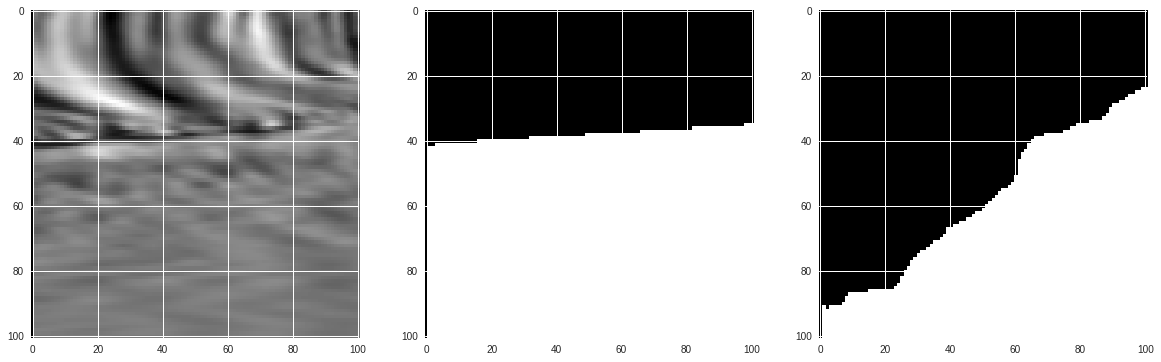

In [58]:
model.cpu()
threshold=0.5
fig, axeslist = plt.subplots(ncols=3,nrows=1)

x,y,d =train_dataset[66]
axeslist.ravel()[0].imshow(x.detach().numpy(),cmap='gray')
axeslist.ravel()[1].imshow(y.detach().numpy(),cmap='gray')
print(x.shape)
z = model(x.view(1,101,101),d)
z = ((z>(1-threshold)) * (z<(1+threshold))).float()
axeslist.ravel()[2].imshow(z.squeeze(0).detach().numpy(),cmap='gray')
print(z.shape)
# def getImg(x):
#     x = x.view(1,3,101,101)
#     x = model(x).detach().squeeze(0).numpy()[0]
#     x = (x-x.mean()/(x.max()-x.min())) +1
#     a = np.expand_dims(x, axis = 2)
#     a = np.concatenate((a, a, a), axis = 2)
#     return a
# print(y.shape)
# predict = (F.sigmoid(z) > 0.5).detach().numpy().squeeze(0)
# axeslist.ravel()[3].imshow(predict,cmap='gray')


# # axeslist.ravel()[1].imshow(getImg(y),cmap='gray')

# axeslist.ravel()[2].imshow(y.detach().numpy(),cmap='gray')
plt.show()

In [0]:
|x = torch.randn(1,3,101,101)
plt.imshow(x.numpy().squeeze(0)[0])

In [0]:
torch.save(model,'TGSUNetsimple23.pt')
uploaded = drive.CreateFile({'title': 'TGSUNetsimple23.pt'})
uploaded.SetContentFile('TGSUNetsimple23.pt')
uploaded.Upload()

In [0]:
model = torch.load('TGSUNetsimple23.pt')

In [0]:
downloaded = drive.CreateFile({'id': '1Gs1AlcVL9WNlgHQPSpNvbFtSbqNFZIdu'})
downloaded.GetContentFile('test.zip')
with ZipFile("test.zip", 'r') as z:
  z.extractall()
os.remove("test.zip")

In [0]:
class TGSSaltTestDataset(Dataset):
    def __init__(self, image_dir,test_csv):
        self.image_dir=image_dir
#         self.filter = np.array([(0,-1,-1,-1),(1,0,0,0),(1,0,1,0),(0,1,0,1)])/8
        self.input = pd.read_csv(test_csv)
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx,0]+".png")
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        img = torch.tensor(img).view(101,101).float()
#         depth = self.input.iloc[idx,1].reshape(1)
        
        return img,0

In [0]:
batch_size = 10
test_dataset = TGSSaltTestDataset("test/images","test.csv")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
def predict(test_loader):
    test_pred=torch.IntTensor().cuda()
    model.eval()
    for batch_idx,( data,d) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
#             target = target.cuda()
        # forward
        output = model(data,d)
        predictx = ((output) > 0.5).int()
        test_pred=torch.cat((test_pred,predictx.view(batch_size,101,101)),dim=0)
    return test_pred.cpu().numpy()

In [0]:
predict=prediciton(test_loader)
predict=predict.cpu().numpy()

In [0]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# test_dataset.input.drop("z",axis=1,inplace=True)
predicted = predict(test_loader)
test_dataset.input['rle_mask']=np.nan
for i in range(len(test_dataset)):
    test_dataset.input["rle_mask"][i]=rle_encode(predicted[i])

In [0]:
# test_dataset.input.drop(["z"],axis=1,inplace=True)
test_dataset.input.to_csv("submission112.csv",index=False)
uploaded = drive.CreateFile({'title': 'submissions_unet2e10x.csv'})
uploaded.SetContentFile('submission112.csv')
uploaded.Upload()

from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

In [0]:
torch.__version__

In [0]:
test_dataset[6]

In [0]:
model=None
criterion=None

In [0]:
test_dataset.input.columns